<a href="https://colab.research.google.com/github/shayan-fallah/Vgg16/blob/main/FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier Transfrom Analysis

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
!kaggle datasets download -d divg07/casia-20-image-tampering-detection-dataset -p /content/gdrive/MyDrive/CASIA2_with_mask --unzip


Dataset URL: https://www.kaggle.com/datasets/divg07/casia-20-image-tampering-detection-dataset
License(s): unknown
100% 2.54G/2.56G [00:18<00:00, 255MB/s]
100% 2.56G/2.56G [00:18<00:00, 147MB/s]


In [ ]:
import cv2
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import os
import random
from skimage.io import imread
from skimage.color import rgb2gray

In [ ]:
def show_fft_amplitude_phase_subplot(image, size=(224,224), cmap_phase='twilight', cmap_amp='gray', axes=None):
    """
    Compute and plot FFT amplitude (log scale) and phase on given axes.

    Parameters:
    - image: 2D numpy array (grayscale)
    - size: tuple, image resize shape
    - cmap_phase: colormap for phase
    - cmap_amp: colormap for amplitude
    - axes: list or array of 2 matplotlib axes for amplitude and phase
    """
    if image.shape != size:
        img_resized = resize(image, size, anti_aliasing=True)
    else:
        img_resized = image

    F = np.fft.fft2(img_resized)
    F_shifted = np.fft.fftshift(F)

    amplitude = np.abs(F_shifted)
    phase = np.angle(F_shifted)

    # Log scale amplitude for better visualization
    log_amp = np.log1p(amplitude)

    if axes is not None and len(axes) == 2:
        axes[0].imshow(log_amp, cmap=cmap_amp, interpolation='nearest')
        axes[0].set_title("FFT Amplitude (log scale)")
        axes[0].axis('off')

        axes[1].imshow(phase, cmap=cmap_phase, interpolation='nearest')
        axes[1].set_title("FFT Phase")
        axes[1].axis('off')

In [ ]:
def process_random_images(directory, n=5, size=(224,224)):
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    all_files = [f for f in os.listdir(directory) if f.lower().endswith(valid_exts)]

    if len(all_files) < n:
        print(f"Warning: only {len(all_files)} images found, less than requested {n}.")
        n = len(all_files)

    selected_files = random.sample(all_files, n)

    for filename in selected_files:
        filepath = os.path.join(directory, filename)
        img = imread(filepath)
        if img.ndim == 3:
            img = rgb2gray(img)

        if img.shape != size:
            img_resized = resize(img, size, anti_aliasing=True)
        else:
            img_resized = img

        print(f"Processing: {filename}")

        fig, axs = plt.subplots(1, 3, figsize=(15,5))

        axs[0].imshow(img_resized, cmap='gray')
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        show_fft_amplitude_phase_subplot(img_resized, size=size, axes=axs[1:])

        plt.tight_layout()
        plt.show()

In [ ]:
path = '/content/gdrive/My Drive/CASIA_dataset/CASIA2/Tp/'
process_random_images(path, n=3, size=(224,224))

NameError: name 'process_random_images' is not defined

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

def zero_center_fft(F, radius):
    """
    Zero out the center low-frequency region of a 2D FFT array.
    Parameters:
    - F: 2D complex numpy array (shifted FFT)
    - radius: int, side length of square region around center to zero
    Returns:
    - Modified FFT array with center zeroed
    """
    F_modified = F.copy()
    M, N = F.shape
    cx, cy = M // 2, N // 2
    half_r = radius // 2
    F_modified[cx - half_r : cx + half_r, cy - half_r : cy + half_r] = 0
    return F_modified

def process_random_images_zero_center_fft(directory, n=5, size=(224,224), zero_radius=20):
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    all_files = [f for f in os.listdir(directory) if f.lower().endswith(valid_exts)]

    if len(all_files) < n:
        print(f"Warning: only {len(all_files)} images found, less than requested {n}.")
        n = len(all_files)

    selected_files = random.sample(all_files, n)

    for filename in selected_files:
        filepath = os.path.join(directory, filename)
        img = imread(filepath)
        if img.ndim == 3:
            img = rgb2gray(img)
        if img.shape != size:
            img_resized = resize(img, size, anti_aliasing=True)
        else:
            img_resized = img

        print(f"Processing: {filename}")

        # Compute FFT and shift
        F = np.fft.fft2(img_resized)
        F_shifted = np.fft.fftshift(F)

        # Magnitude spectrum before zeroing center
        mag_before = np.log1p(np.abs(F_shifted))

        # Zero center frequencies
        F_zeroed = zero_center_fft(F_shifted, zero_radius)

        # Magnitude spectrum after zeroing center
        mag_after = np.log1p(np.abs(F_zeroed))

        # Inverse FFT for filtered image
        F_zeroed_ishift = np.fft.ifftshift(F_zeroed)
        img_filtered = np.fft.ifft2(F_zeroed_ishift).real

        # Plotting
        fig, axs = plt.subplots(1, 4, figsize=(18,5))

        axs[0].imshow(img_resized, cmap='gray')
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(mag_before, cmap='gray')
        axs[1].set_title("FFT Magnitude (Before)")
        axs[1].axis('off')

        axs[2].imshow(mag_after, cmap='gray')
        axs[2].set_title(f"FFT Magnitude (Center Zeroed, r={zero_radius})")
        axs[2].axis('off')

        axs[3].imshow(img_filtered, cmap='gray')
        axs[3].set_title("Filtered Image (Inverse FFT)")
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()


Processing: Tp_D_NNN_S_N_pla00006_pla00006_00546.tif


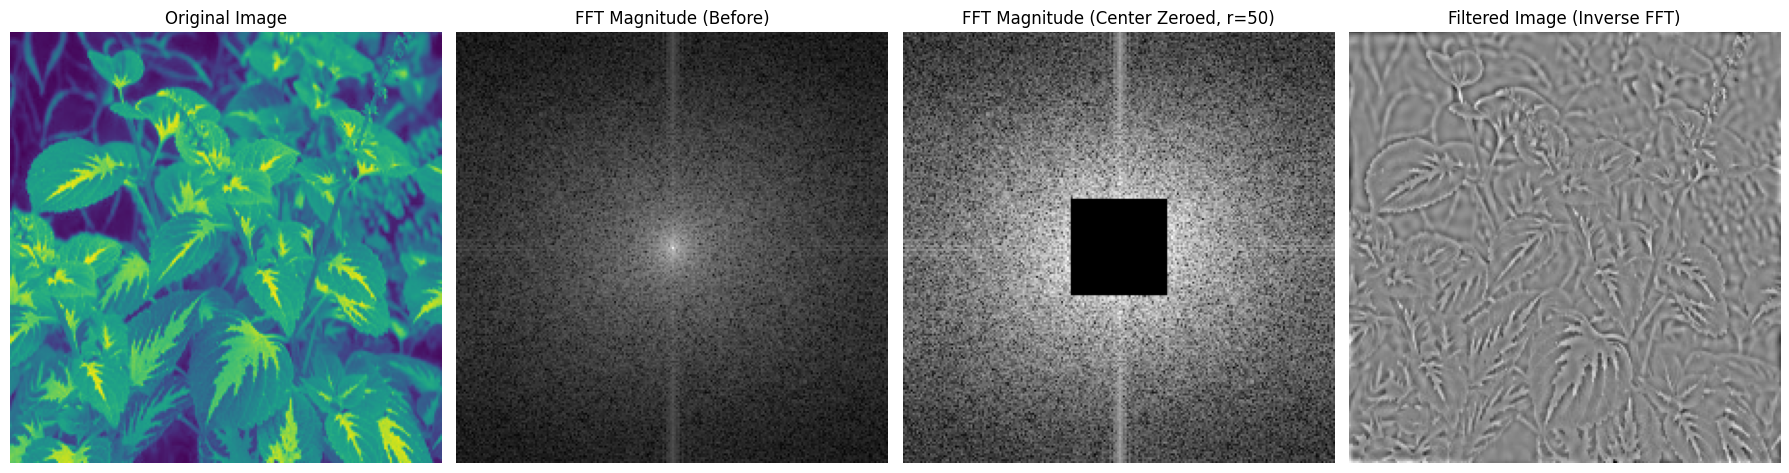

Processing: Tp_S_NNN_S_N_ind00063_ind00063_01351.tif


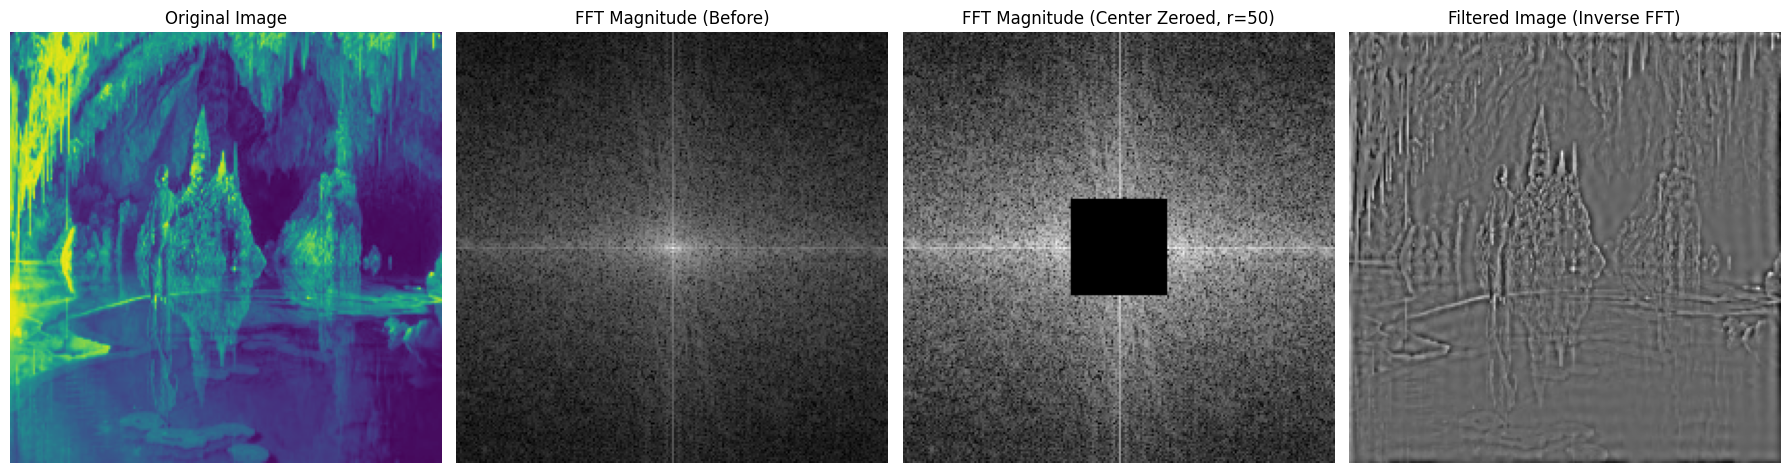

Processing: Tp_S_NRD_S_B_ani00063_ani00063_00183.tif


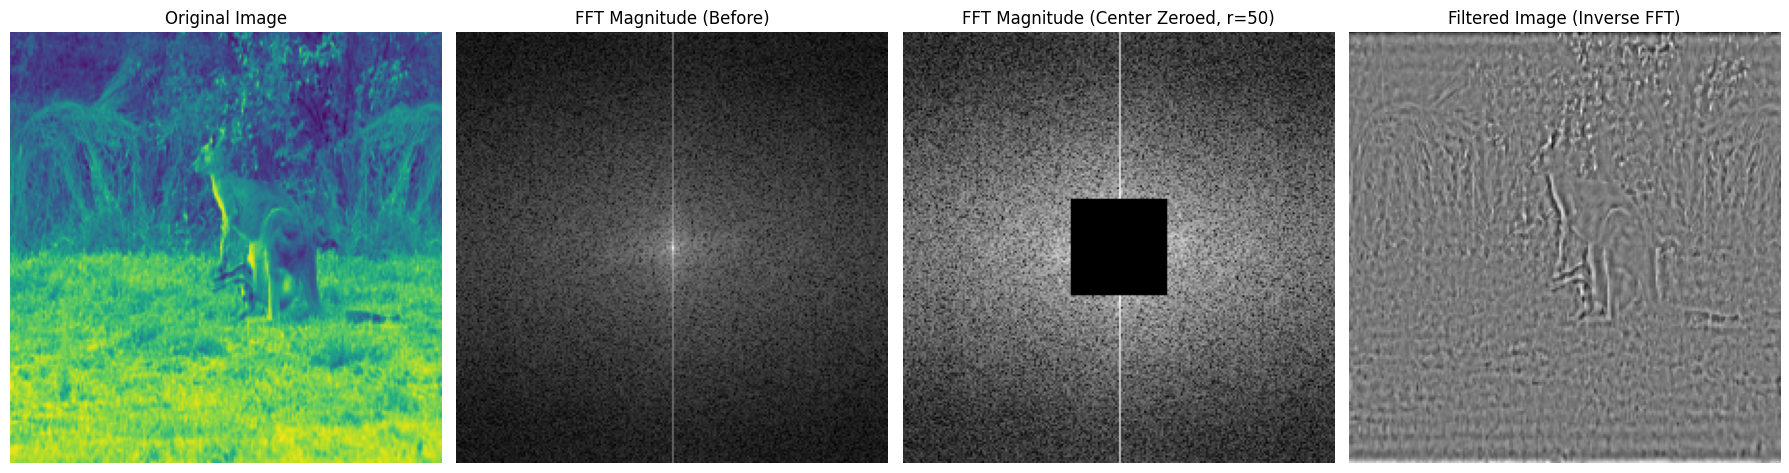

In [ ]:
path = '/content/gdrive/My Drive/CASIA_dataset/CASIA2/Tp/'
process_random_images_zero_center_fft(path, n=3, size=(224,224), zero_radius=20)


In [ ]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from PIL import Image, ImageChops, ImageEnhance

# Zero-center the FFT
def zero_center_fft(F_shifted, zero_radius):
    """Zero out the center frequencies inside a radius."""
    rows, cols = F_shifted.shape
    crow, ccol = rows // 2, cols // 2

    mask = np.ones_like(F_shifted, dtype=bool)
    y, x = np.ogrid[:rows, :cols]
    mask_area = (x - ccol)**2 + (y - crow)**2 <= zero_radius**2
    mask[mask_area] = False

    F_shifted_zeroed = F_shifted * mask
    return F_shifted_zeroed

# ELA image conversion (your existing code)
def convert_to_ela_image2(path, quality=85, size=(128, 128)):
    temp_filename = 'temp_ela.jpg'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    resaved = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, resaved)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image.resize(size)

# Main function
def process_random_images_zero_center_fft2(directory, n=5, size=(224,224), zero_radius=30, ela_size=(128,128)):
    valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    all_files = [f for f in os.listdir(directory) if f.lower().endswith(valid_exts)]

    if len(all_files) < n:
        print(f"Warning: only {len(all_files)} images found, less than requested {n}.")
        n = len(all_files)

    selected_files = random.sample(all_files, n)

    for filename in selected_files:
        filepath = os.path.join(directory, filename)
        img = imread(filepath)

        # Ensure the image is in grayscale before applying FFT (convert from RGB to grayscale if needed)
        if img.ndim == 3:
            img_gray = rgb2gray(img)  # Convert to grayscale if the image is RGB
        else:
            img_gray = img

        if img_gray.shape != size:
            img_resized = resize(img_gray, size, anti_aliasing=True)
        else:
            img_resized = img_gray

        print(f"Processing: {filename}")

        # FFT processing on original image
        F = np.fft.fft2(img_resized)
        F_shifted = np.fft.fftshift(F)

        # Magnitude spectrum of FFT (Original Image)
        mag_original = np.log1p(np.abs(F_shifted))

        # Zero out the center frequencies
        F_zeroed = zero_center_fft(F_shifted, zero_radius)

        # Inverse FFT for reconstructed image
        F_zeroed_ishift = np.fft.ifftshift(F_zeroed)
        img_filtered = np.fft.ifft2(F_zeroed_ishift).real

        # ELA processing on original image
        ela_img = convert_to_ela_image2(filepath, quality=80, size=ela_size)
        ela_img_gray = rgb2gray(ela_img)
        # FFT processing on ELA image
        F_ela = np.fft.fft2(ela_img_gray)
        F_ela_shifted = np.fft.fftshift(F_ela)

        # Magnitude spectrum of FFT (ELA Image)
        mag_ela = np.log1p(np.abs(F_ela_shifted))

        # Zero out the center frequencies for ELA image
        F_ela_zeroed = zero_center_fft(F_ela_shifted, zero_radius)

        # Inverse FFT for reconstructed ELA image
        F_ela_zeroed_ishift = np.fft.ifftshift(F_ela_zeroed)
        ela_img_filtered = np.fft.ifft2(F_ela_zeroed_ishift).real

        # Plotting (show all four images)
        fig, axs = plt.subplots(1, 5, figsize=(22,5))

        axs[0].imshow(img_resized, cmap='gray')
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(img_filtered, cmap='gray')
        axs[1].set_title("Reconstructed Image (FFT Zero Centered)")
        axs[1].axis('off')

        axs[2].imshow(ela_img)
        axs[2].set_title("ELA Filtered  Image")
        axs[2].axis('off')

        axs[3].imshow(ela_img_gray, cmap='gray')
        axs[3].set_title("ELA Filtered gray Image")
        axs[3].axis('off')

        axs[4].imshow(ela_img_filtered, cmap='gray')
        axs[4].set_title("Reconstructed ELA Image (FFT Zero Centered)")
        axs[4].axis('off')

        plt.tight_layout()
        plt.show()


Processing: Au_ani_10208.jpg


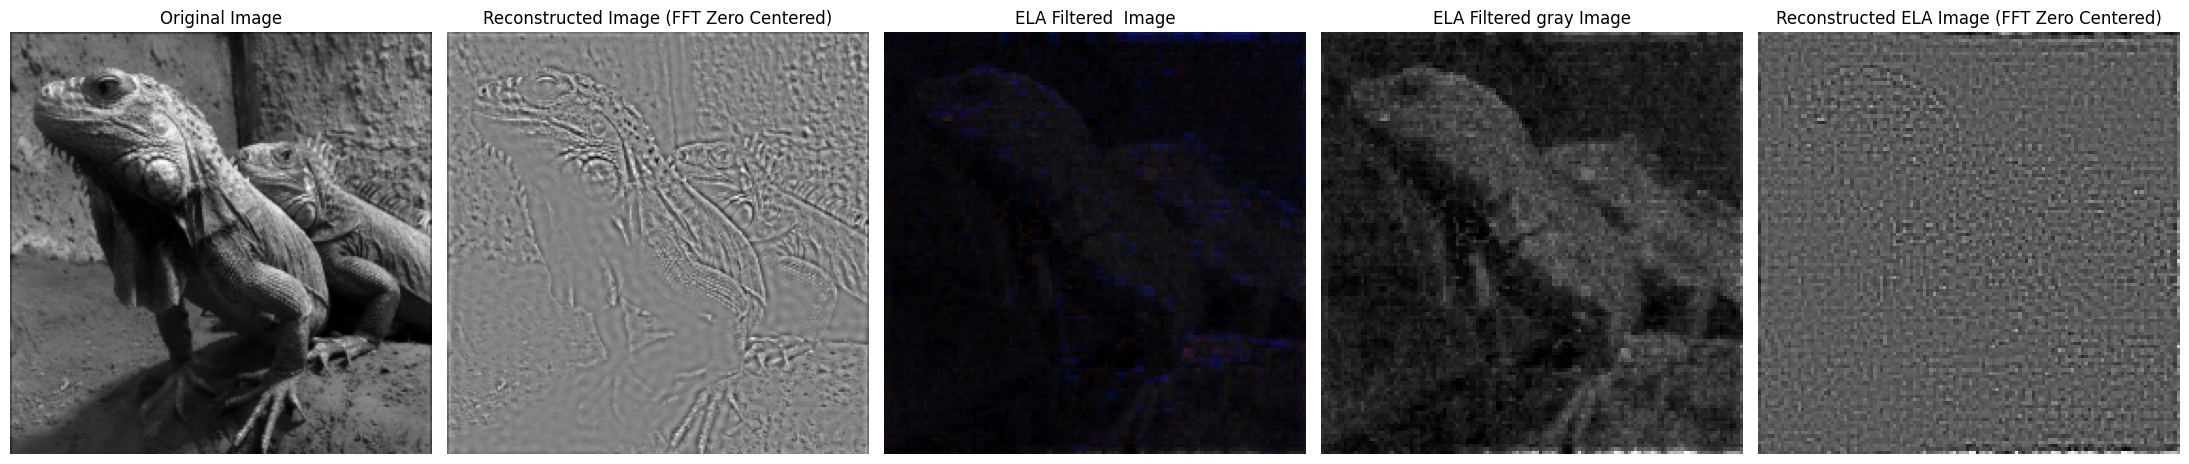

Processing: Au_nat_20035.jpg


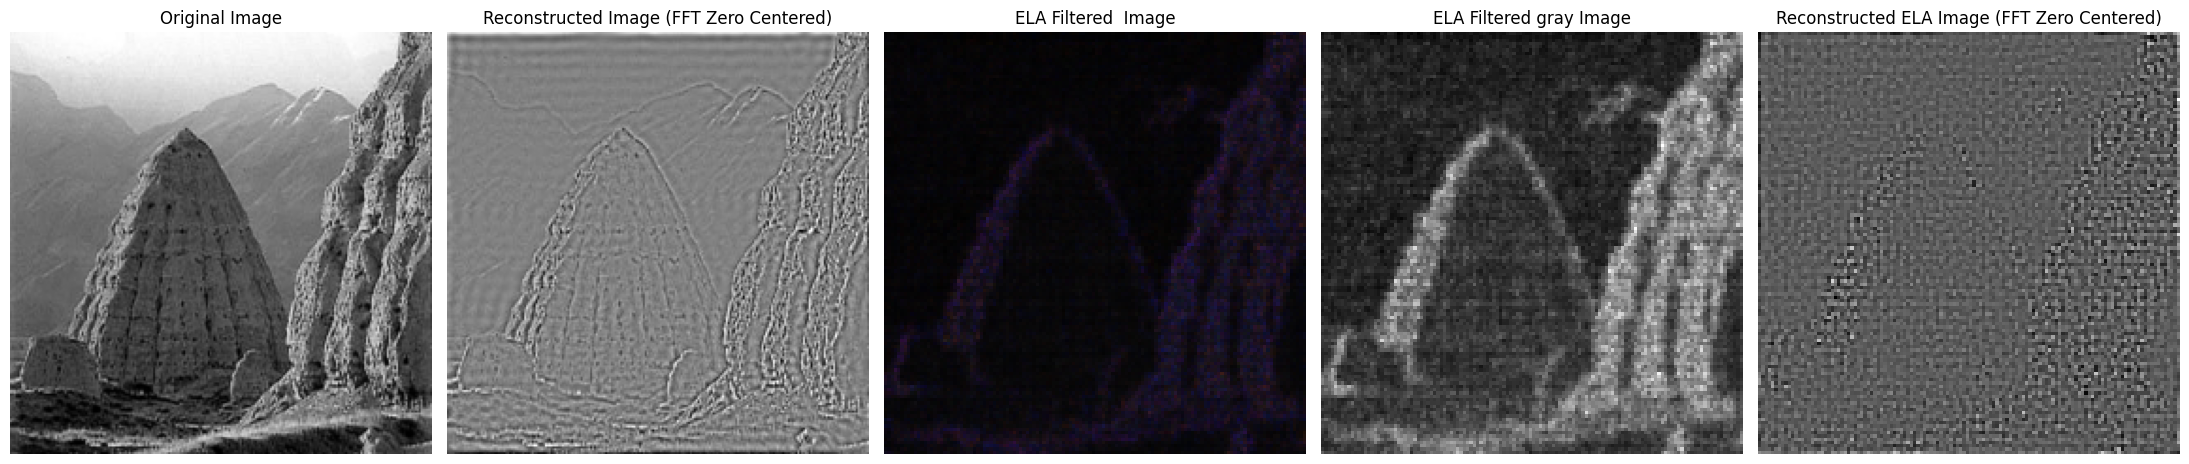

Processing: Au_sec_30279.jpg


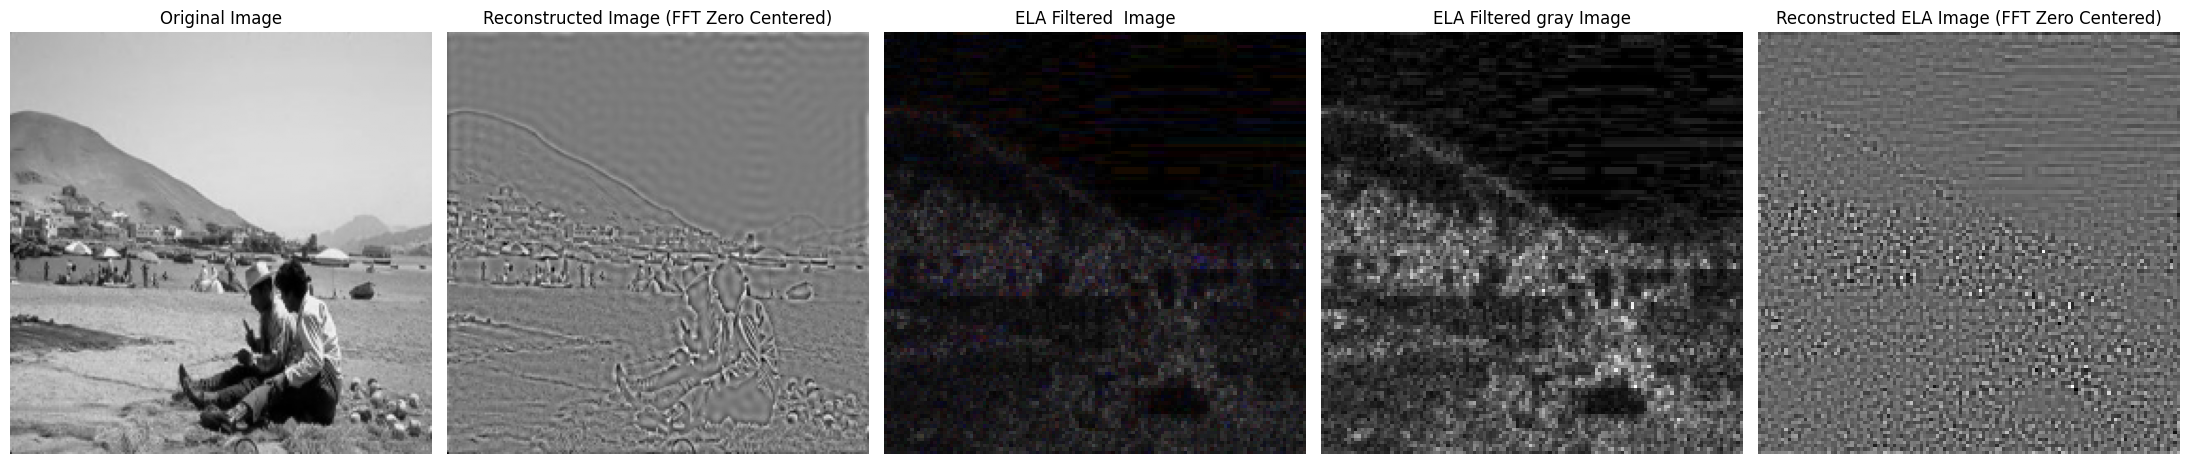

Processing: Tp_S_NNN_S_B_nat00059_nat00059_00971.tif


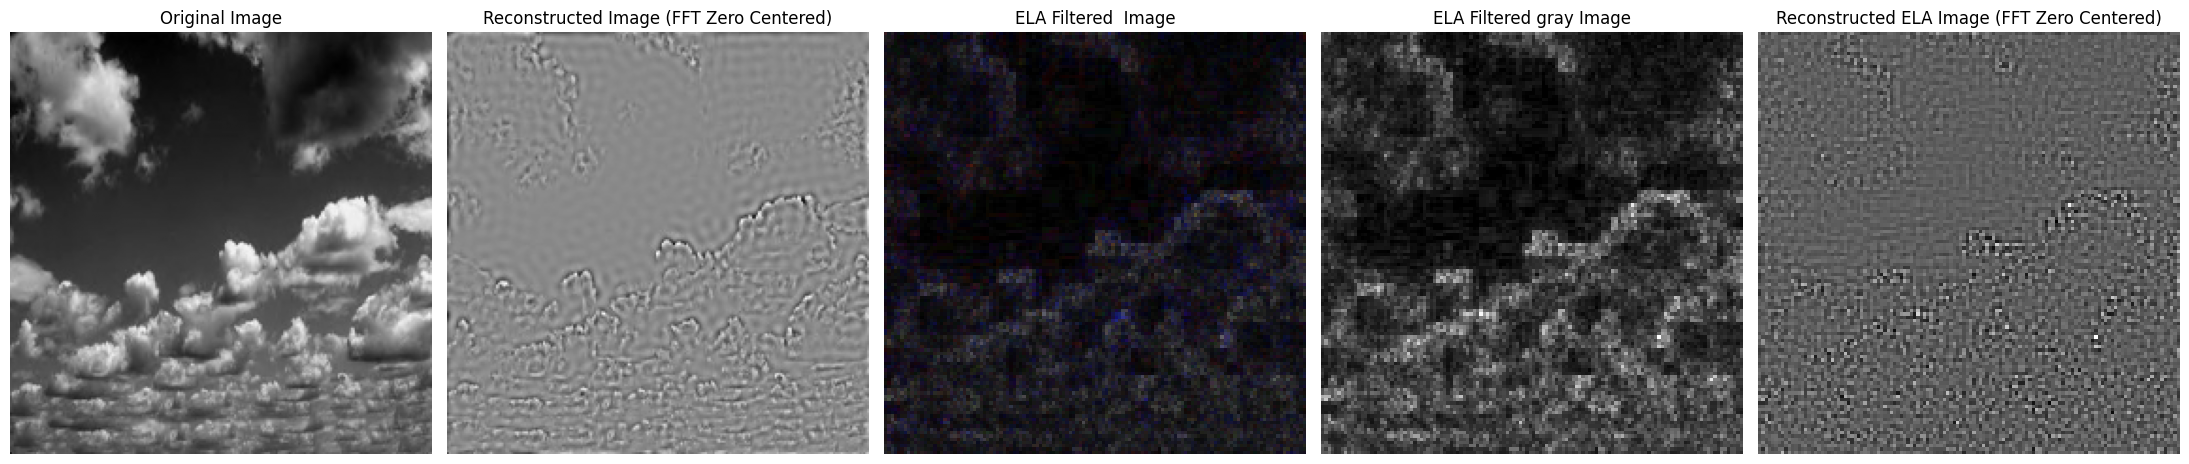

Processing: Tp_D_NNN_M_B_art00069_nat00013_11844.jpg


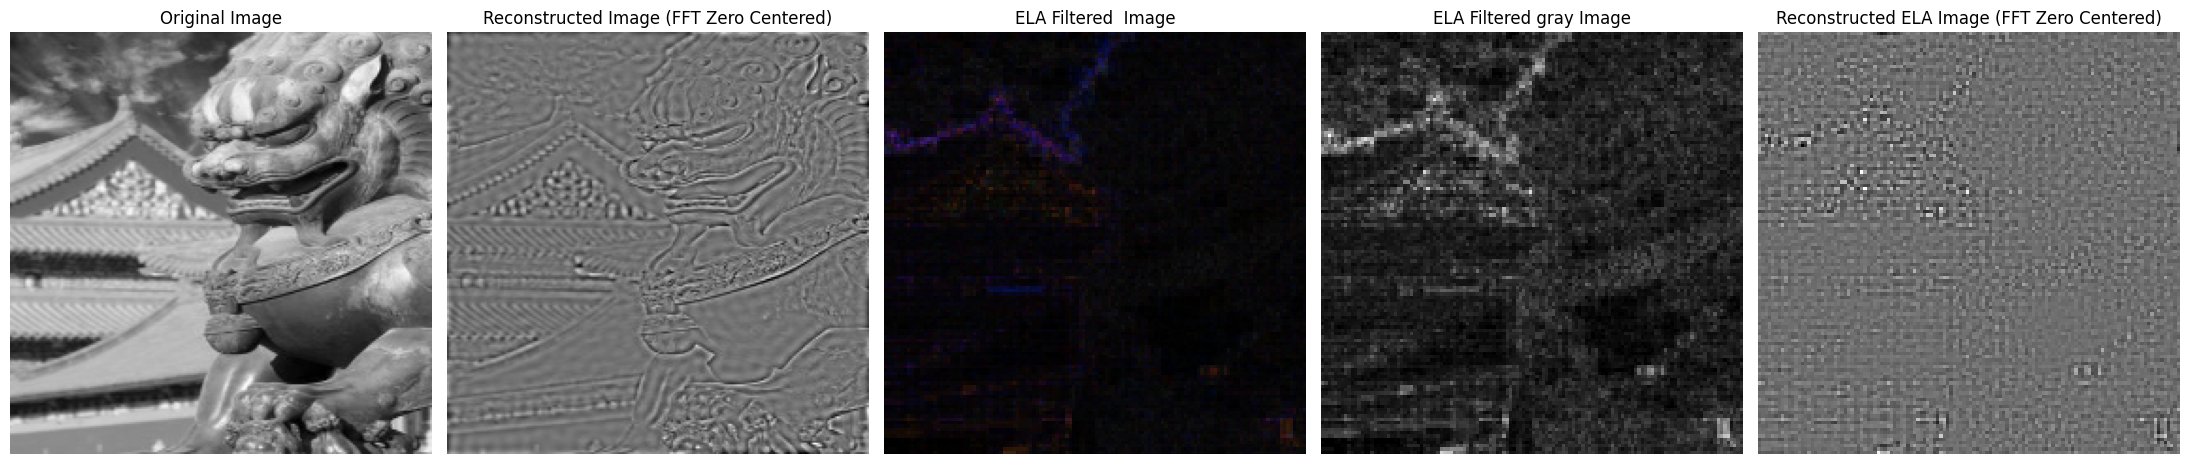

Processing: Tp_D_NNN_M_N_cha10168_cha10140_12301.jpg


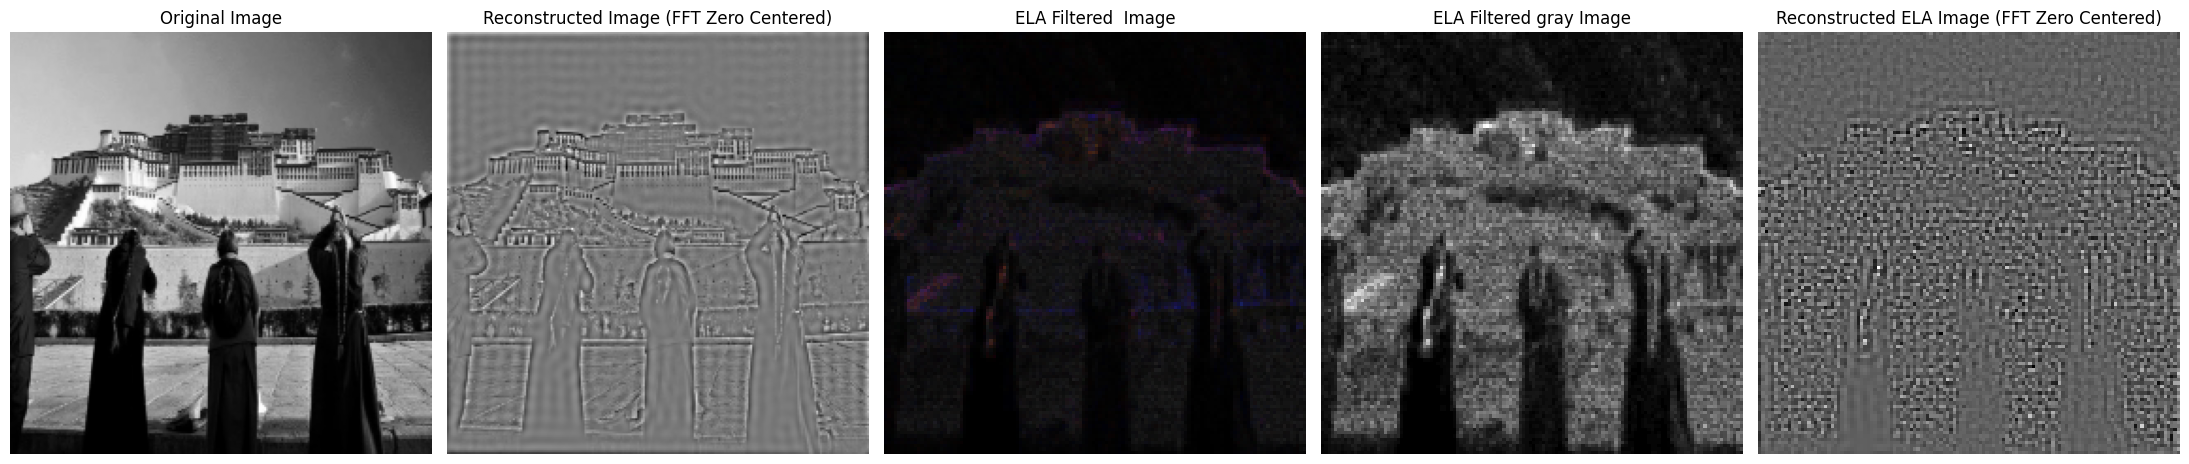

In [ ]:
path_au = '/content/gdrive/My Drive/CASIA_dataset/CASIA2/Au/'
path_tp = '/content/gdrive/My Drive/CASIA_dataset/CASIA2/Tp/'
process_random_images_zero_center_fft2(path_au, n=3, size=(224,224), zero_radius=30)
process_random_images_zero_center_fft2(path_tp, n=3, size=(224,224), zero_radius=30)
